<a href="https://colab.research.google.com/github/sundarjhu/AstrostatsIRyA2023/blob/main/Statistics_For_Astronomers_20230911.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we will visualise chi-squared minimisation for two simple models: a constant and a line.

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

## Setting up
##### We will define some functions here that will be used in both cases

In [233]:
from numpy.lib.utils import safe_eval
def chisq(A, B, x, y, y_err):
  """
    Given data arrays (x, y) and the corresponding
    array of uncertainties y_err, return the chi-squared
    for the model specified by
    (1) $y = (A + B x) + \epsilon$
    (2) $\epsilon\sim\mathscr{N}(0, \sigma^2)$
    That is, y is different from the linear model only because
      of Gaussian noise with standard deviation $\sigma$.

    If B is set to zero, then the model is a constant of value A.
  """
  return (((y - A - B * x) / y_err)**2).sum()

def min_chisq(x, y, y_err):
  """
    Given data arrays (x, y) and the corresponding
    array of uncertainties y_err, return the
    theoretical values of the parameters of the best-fit
    line, which are obtained by setting the partial derivatives
    of the chi-squared w.r.t. each parameter to zero.
  """
  s = (1 / y_err**2).sum()
  s_x = (x / y_err**2).sum()
  s_xx = (x**2 / y_err**2).sum()
  s_xy = (x*y / y_err**2).sum()
  s_y = (y / y_err**2).sum()

  Gamma = 1 / (s_x**2 - s_xx * s)
  A_best = -Gamma * (s_xx * s_y - s_xy * s_x)
  B_best = Gamma * (s_x * s_y - s_xy * s)

  return A_best, B_best

def make_data(A_true, B_true, N_data=15):
  """
    Simulate data from a straight-line model with uncertainties.
    Arguments:
      A_true, B_true: true value of intercept and slope
      N_data: number of data points to return
    Returns:
      x, y: independent and dependent variable values
      y_err: uncertainties in dependent variable
  """
  x = np.linspace(0, 10, 15)
  np.random.seed(1001) # for reproducibility
  y_err = norm.rvs(loc=0.35, scale=0.05, size=len(x))
  y = A_true + B_true * x + norm.rvs(scale=y_err)

  return x, y, y_err

def plot_data(x, y, y_err, A_true, B_true):
  """
  Plot the observations and compare them to the true relationship
  Arguments:
  x, y: independent and dependent variable values
  y_err: uncertainty in the dependent variable
  A_true, B_true: true values of the intercept and slope
  """
  plt.errorbar(x, y, yerr=y_err, linestyle='none')
  plt.plot(x, y, 'ro', label='data')
  ylim = plt.ylim()
  plt.ylim(ylim[0] * 0.9, ylim[1] * 1.1)
  xlim = np.array(plt.xlim())
  plt.xlim(xlim[0] * 0.9, xlim[1] * 1.1)
  plt.plot(xlim, A_true + B_true * xlim, 'k--', label='True relation')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(loc='best')
  plt.show()

# def plot_fit(x, y, y_err, A_true, B_true):
#   """
#   Plot the observations and compare them to the true and best-fit line
#   """
#   from scipy.stats import chi2 as chi2dist
#   # Degrees of freedom
#   dof = len(x) - 1 # decrease by one if slope is a free parameter (see below)
#   if B_true != 0:
#     dof -= 1
#   # Confidence
#   alpha = 0.68
#   # Compute a 68% equal-tailed confidence interval for chi2(dof) and use
#   #   it to get the range of A, B values
#   c1, c2 = chi2dist.ppf((1 - alpha) / 2, dof), chi2dist.ppf((1 + alpha) / 2, dof)
#   k_range = np.nonzero((chi2 >= c1) & (chi2 <= c2))[0]
#   A_range, B_range = A_grid[k_range], B_grid[k_range]
#   for a, b in zip(A_range, B_range):
#     plt.plot(x, a + b * x, 'k-', alpha=0.2)



def chisq_minimise(A_range, B_range, x, y, y_err):
  """
  Minimise \chisq and return the best-fit values of the intercept and slope.
  Also visualise the \chisq as a function of the parameters. If slope==0,
    the plot will be 2D. If not, show a contour and surface plot for \chisq
    as a function of the slope and intercept, comparing it to the value
    for the best-fit intercept and slope.
  Arguments:
  x, y: independent and dependent variable values
  y_err: uncertainties for dependent variable
  A_range, B_range: tuples containing the minimum and maximum values to
    explore for the intercept and slope.
  """
  # Get the minimum values of A and B by equating
  #   the partial derivatives of \chisq w.r.t.
  #   each parameter to zero
  A_th, B_th = min_chisq(x, y, y_err)
  print(f"Best-fit parameter values by minimising chi-squared:\n"
  f"A={np.round(A_th, decimals=2)}, B={np.round(B_th, decimals=2)}")
  #
  # Visualise the variation of \chisq with A and B,
  #   and the location of the minimum \chisq
  A_grid = np.linspace(A_range[0], A_range[1], 1000)
  B_grid = np.linspace(B_range[0], B_range[1], 1000)
  #
  # If 1-dimensional (B = 0), plot chisq vs A.
  if B_range[0] == B_range[1]:
    chi2 = [chisq(AA, BB, x, y, y_err) for AA, BB in zip(A_grid, B_grid)]
    loc_min = np.argmin(chi2)
    A_min, B_min = A_grid[loc_min], B_grid[loc_min]
    plt.plot(A_grid, chi2, 'k-')
    plt.plot([A_min, A_min], [chi2[loc_min], chi2[loc_min]], 'ro', label='minimum')
    ylim = plt.gca().get_ylim()
    plt.plot([A_true, A_true], ylim, 'k-', label='True value of $A$')
    plt.plot([A_th, A_th], ylim, 'k--', label='Best-fit $A$ from minimisation')
    plt.xlabel('A')
    plt.ylabel(r'$\chi^2(A|y)$')
    plt.legend(loc='best')
    plt.show()
    print(f"The minimum chi-square, found graphically, was {np.round(chi2[loc_min], decimals=2)}"
    f" for A={np.round(A_min, decimals=2)} and B={np.round(B_min, decimals=2)}.")

  # If 2-dimensional (B != 0), show a contour plot of chisq vs (A, B).
  else:
    A_mesh, B_mesh = np.meshgrid(A_grid, B_grid)
    chi2 = np.array([chisq(AA, BB, x, y, y_err) for AA, BB in
                     zip(A_mesh.flatten(), B_mesh.flatten())]).reshape(A_mesh.shape)
    loc_min = np.unravel_index(np.argmin(chi2), chi2.shape)
    A_min, B_min = A_mesh[loc_min], B_mesh[loc_min]
    from mpl_toolkits.mplot3d import Axes3D
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    cf = ax1.contourf(A_mesh, B_mesh, chi2, levels=15)
    fig.colorbar(cf, ax=ax1)
    ax1.scatter(A_min, B_min, color='red')
    ax1.set_xlabel('A')
    ax1.set_ylabel('B')
    ax1.set_title(r'Contour plot of $\chi^2(A, B|y)$')
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(A_mesh, B_mesh, chi2)
    zl = ax2.get_zlim()
    zlim = [0.09 * zl[0], 1.1 * zl[1]]
    ax2.plot([A_min, A_min], [B_min, B_min], zlim, 'r--', linewidth=3, zorder=10)
    ax2.plot([A_min, A_min], [B_min, B_min], [zlim[0], zlim[0]], 'ro')
    ax2.set_xlabel('A')
    ax2.set_ylabel('B')
    ax2.set_zlabel(r'$\chi^2(A, B|y)$')
    plt.show()
    print(f"The minimum chi-square, found graphically, was {np.round(chi2[loc_min], decimals=2)}"
    f" for A={np.round(A_min, decimals=2)} and B={np.round(B_min, decimals=2)}.")


## Case 1: y = constant + noise

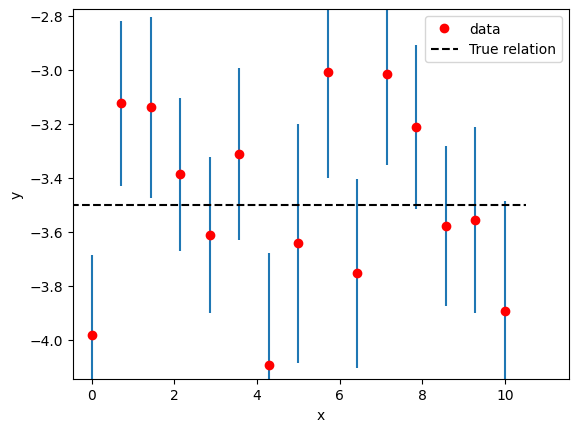

Best-fit parameter values by minimising chi-squared:
A=-3.47, B=-0.0


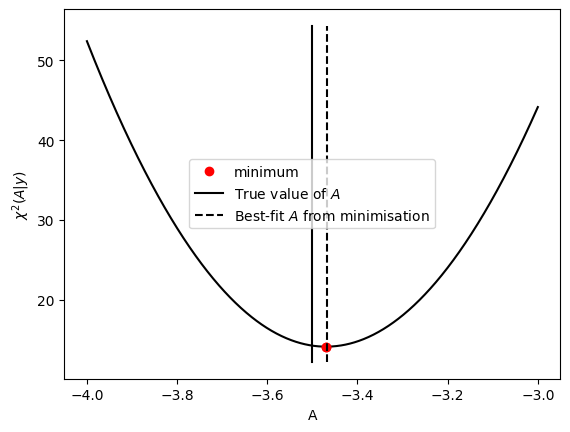

The minimum chi-square, found graphically, was 14.09 for A=-3.47 and B=0.0.


In [234]:
N_data = 15
A_true, B_true = -3.5, 0.0
x, y, y_err = make_data(A_true, B_true, N_data=N_data)
plot_data(x, y, y_err, A_true, B_true)
chisq_minimise((-4, -3), (0, 0), x, y, y_err)

##### Note that the true value of the intercept is different from the calculated value. This is due to the relatively low signal-to-noise in the data, which results in considerable variability around the constant value.

## Case 2: y = intercept + slope * x + noise

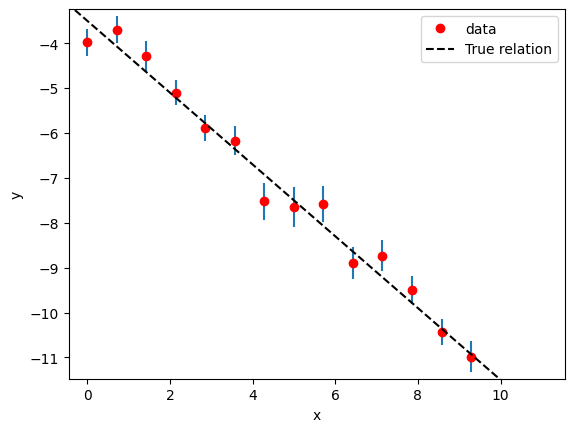

Best-fit parameter values by minimising chi-squared:
A=-3.47, B=-0.8


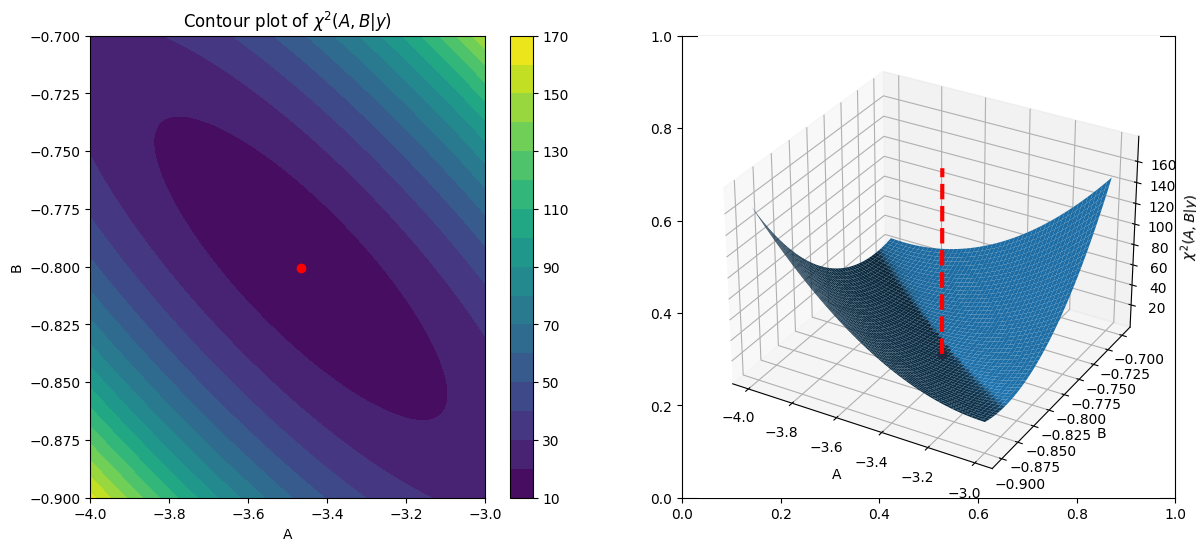

The minimum chi-square, found graphically, was 14.09 for A=-3.47 and B=-0.8.


In [235]:
N_data=15
A_true, B_true = -3.5, -0.8
x, y, y_err = make_data(A_true, B_true, N_data=15)
plot_data(x, y, y_err, A_true, B_true)
chisq_minimise((-4, -3), (-0.9, -0.7), x, y, y_err)

##### A couple of things to note here:
##### 1. There's a linear anticorrelation between the slope and intercept, as discussed in previous lectures!
##### 2. The location of the minimum $\chi^2$ is not well constrained especially along the intercept dimension. This is evident from the comparatively longer major axis length of the contours, as well as the relatively flat surface along the corresponding direction on the surface plot.

## Total number of points: 15. Total number of parameters: 2 $\Longrightarrow$ number of degrees of freedom = 13.

##### The $\chi^2$ studied above must therefore have a $\chi^2$ distribution with 13 degrees of freedom.
##### Recall that $\mathbb{E}[\chi^2(\nu=13)] = 13, {\rm Var}[\chi^2(\nu=13)] = 26\Longrightarrow \sigma\approx 5$.
##### The {\bf observed value} of $\chi^2$ is 14.09 (see printout above).
##### We can calculate the probability of observing a value of 14.09 or higher.

In [218]:
from scipy.stats import chi2
chisq = chi2(df=13)

In [221]:
pvalue = 1 - chisq.cdf(14.09)
print(f"The probability of obtaining a value higher than the observed value is {np.round(pvalue, decimals=2)}")

The probability of obtaining a value higher than the observed value is 0.37


##### Therefore, obtaining a value of 14.09 for a $\chi^2$ with 13 degrees of freedom is **nothing to panic about**.

## In terms of the reduced $\chi^2$
##### For this problem, $\chi^2_{_{\rm red}} \equiv \displaystyle{1\over 13}\chi^2$
##### Recall that $\mathbb{E}[\chi^2_{_{\rm red}}]=1$ and ${\rm Var}[\chi^2_{_{\rm red}}]=\displaystyle{2\over 13}\approx 0.15\Longrightarrow \sigma\approx 0.4$.
##### Observed value: $14.09/13\approx 1.08$, which is well within the variance.
## Again, **nothing to cause alarm**.